<h1 style="text-align:center">Planar Crane Example</h1>
<h3 style="text-align:center">MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

In this example, we'll determine the equations of motion for the planar crane model shown in Figure 1. The system consists of a point mass, $m$, connected to the crane trolley, which has mass $m_t$, by an ideal pin via a massless rod of length $l$. The rotation of the suspension cable is represented by $\theta$. There is a force, $f$, acting on the crane trolley.

<p style="text-align:center">
	<img src="http://shared.crawlab.org/crane_forwardAngle.png" alt="Planar Crane" width=35%><br>
    <strong>Figure 1: Planar Crane Model</strong>
</p>

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Define the genearlized coordinates and other dynamic symbols
x, theta, f = dynamicsymbols('x theta f')

# Also define the first derivatives
x_dot, theta_dot = dynamicsymbols('x theta', 1)

# Define the symbols for the other paramters
m, mt, g, l, t = sympy.symbols('m, m_t, g, l, t')

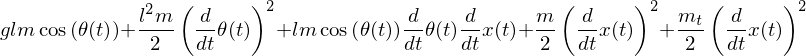

In [3]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the pendulum, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [theta, N.z])

# Define the trolley point and its velocity
T = Point('T')
T.set_vel(N, x_dot * N.x)

# Treat the trolley as a particle
mtr = Particle('mtr', T, mt)

# Define the payload point and set its velocity
P = Point('P')
P.set_vel(N, x_dot * N.x + l * theta_dot * A.x)

# The payload is a particle (a point mass)
mp = Particle('mp', P, m)

# Define the potential energy of the payload - just gravity here
mp.potential_energy = -m * g * l * sympy.cos(theta)

# Set up the force list - each item follows the form:
#    (the location where the force is applied, its magnitude and direction)
forces = [(T, f * N.x)]

# Form the Lagrangian, then simplify and print
L = Lagrangian(N, mtr, mp)
L.simplify()

In [4]:
# This creates a LagrangesMethod class instance that will allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [x, theta], forcelist = forces, frame = N)

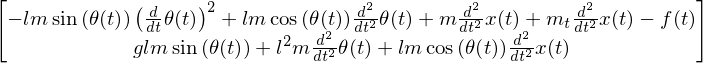

In [5]:
LM.form_lagranges_equations()

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.

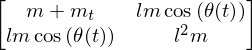

In [6]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

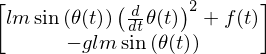

In [7]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the sytsem as a set of first order ODEs, suitable for simluation.

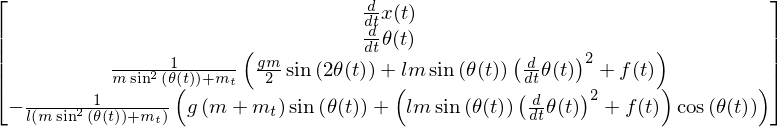

In [8]:
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

We can also linearize these equations with builtin SymPy methods. Let's do so about the operating point:

$$ x = \dot{x} = \theta = \dot{\theta} = 0 $$

The resulting equations returned are a system of first order ODEs in state-space form:

$$ \dot{x} = Ax + Bu $$

See the [SymPy Documentation](http://docs.sympy.org/0.7.6/modules/physics/mechanics/linearize.html#linearizing-lagrange-s-equations) for much more information.

In [9]:
# Define the point to linearize around
operating_point = {x: 0.0, x_dot: 0.0, theta: 0.0, theta_dot: 0.0}

# Make the call to the linearizer
A, B, inp_vec = LM.linearize([x, theta], 
                             [x_dot, theta_dot],
                             op_point = operating_point, 
                             A_and_B = True)

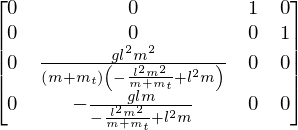

In [10]:
A

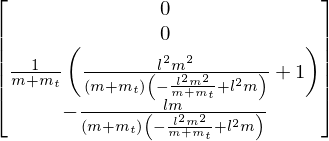

In [11]:
B

Given these two matrices, the system of equations match those that we'd expect:

$$ \begin{bmatrix}\dot{w}_1 \\ \dot{w}_2 \\ \dot{w}_3 \\ \dot{w}_4\end{bmatrix} = A \begin{bmatrix}w_1 \\ w_2 \\ w_3 \\ w_4 \end{bmatrix} + B f(t)$$

where:

$$ \mathbf{w} = \begin{bmatrix}w_1 \\ w_2 \\ w_3 \\ w_4 \end{bmatrix} = \begin{bmatrix}x \\ \theta \\ \dot{x} \\ \dot{\theta}\end{bmatrix} $$

## Simulation
We can pass these equations of motion to numerical solver for simluation. To do so, we need to import [NumPy](http://numpy.org) and the [SciPy](http://www.scipy.org) ode solver, ```ode```. We'll also import [matplotlib](http://www.scipy.org) to enable plotting of the results.

For a system as simple as this one, we could easily set up the necessary components for the numerical simulation manually. However, here will automate as much as possible. Following a similar procedure on more complicated systems would be necessary.

In [12]:
# import NumPy with namespace np
import numpy as np

# import the ode ODE solver
from scipy.integrate import ode

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

Let's define the forcing function, so that it can be substituted into the generated equations of motion. Here, we'll use a simple bang-bang input.

In [13]:
# define the forcing function
def force(t):
    # set the maximum force output
    fmax = 10.0
    
    # return a bang-bang command
    return fmax * ((t > 0.25) - 2 * (t >= 1.25) + (t >= 2.25))

Let's plot the input to make sure it matches the bang-bang profile we precribed.

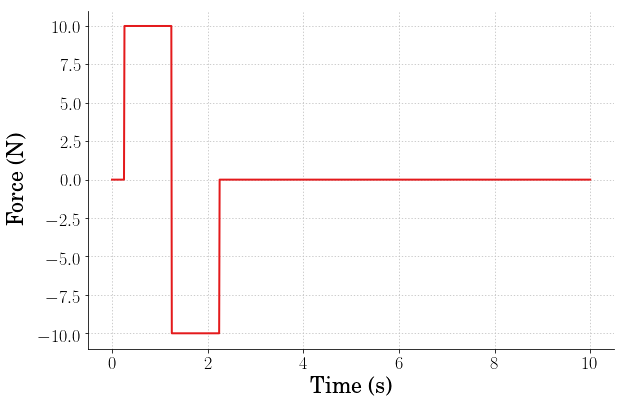

In [14]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Force (N)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the force over 10 seconds
force_plot_time = np.linspace(0.0, 10.0, 1001)
plt.plot(force_plot_time, force(force_plot_time), linewidth=2, linestyle='-', label=r'Force')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(0, 10)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Bang_Bang_Force.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

From this plot, you can see why this type of command is called bang-bang. It "bangs" on, then "bangs" negative, then is zero for all other time.

Now, let's continue setting up the simluation by creating a version of the generated equations of motion that we can use in a numerical ODE solver.

In [15]:
# Define the states and state vector
w1, w2, w3, w4 = sympy.symbols('w1 w2 w3 w4', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              theta : w2(t), 
              x_dot : w3(t),
              theta_dot : w4(t), 
              mt : 10.0,
              m : 1.0,
              g : 9.81, 
              l : 2.0, 
              f: force(t)}

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params))

In [16]:
# Set up the initial conditions for the solver
x_init = 0.0                   # Initial trolley position (m)
x_dot_init = 0.0               # Initial trolley velocity (m/s)
theta_init = 0.0 * np.pi/180   # Initial angle (rad)
theta_dot_init = 0.0           # Initial angular velocity (rad/s)

# Pack the initial conditions into an array
x0 = [x_init, theta_init, x_dot_init, theta_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 10.0, 1001) # 0-10s with 1001 points in between

In [17]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

Now, let's plot the results. The first column of the ```response``` vector is the position of the trolley, $x$, and the second column of the ```response``` vector is the angle of the pendulum, $\theta$. We'll plot both below, after setting up plotting parameters to make the plot more readable.

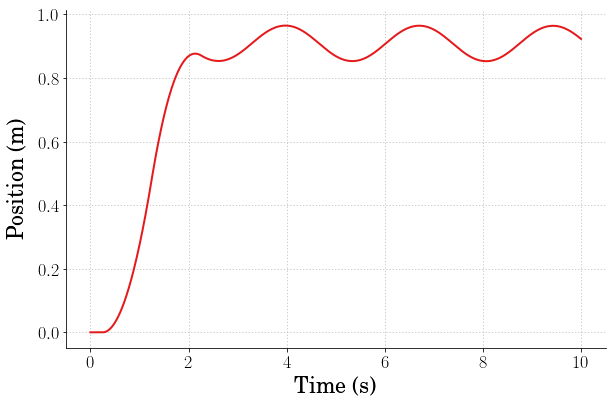

In [18]:
# Plot the payload response

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = '$x$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Trolley_Response.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

Now, let's plot the suspension cable angle, $\theta$.

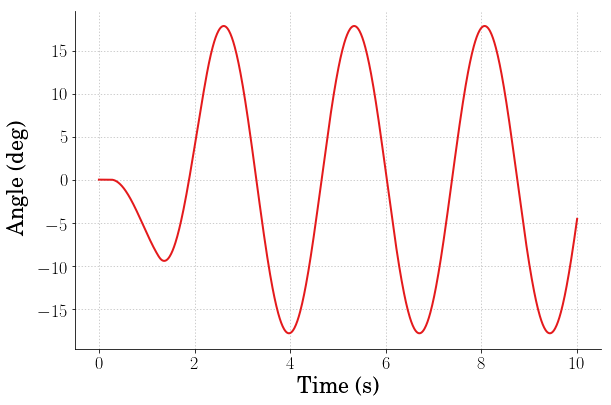

In [19]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 1] * 180/np.pi, linewidth=2, linestyle='-', label = '$\theta$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Payload_Response.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

We can also plot the horizontal position of the trolley and payload over time, to better understand how they interact. To do so, we need to define the horizontal position of the payload, $x_p$. It is simply the position of the trolley, $x$, plus the horizontal position of the point mass relative to it, $l\sin{\theta}$:

$$ x_p = x + l\sin{\theta} $$

In [20]:
# Define the horizontal position of the payload
xp = response[:,0] + 2.0 * np.sin(response[:,1])

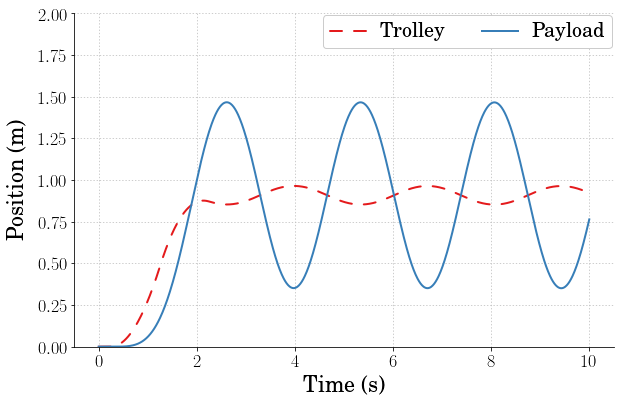

In [21]:
# Now plot the responses together

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='--', label = 'Trolley')
plt.plot(sim_time, xp, linewidth=2, linestyle='-', label = 'Payload')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(0, 2)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('TrolleyAndPayload_Response.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

Given our choice of masses, we see that the payload is able to back-drive the trolley, causing the trolley to move opposite of the payload once the bang-bang command is over.

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [22]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))